# A Weighted Similarity Metric for Community Detection in Sparse Data

This notebook defines a weighted similarity metric. Many Natural Language Processing (NLP) related applications involves topics and sentiments derived from short documents such as consumer reviews and social media posts. Topics and sentiments of short documents are highly sparse because a short document generally covers a few topics among hundreds of candidates. Imputation of missing data is sometimes hard to justify and also often unpractical in highly sparse data. We developed a method for calculating a weighted similarity for highly sparse data without imputation. This weighted similarity is consist of three components to capture similarities based on both existence and lack of common properties and pattern of missing values. As a case study, we used a community detection algorithm and this weighted similarity to group different shampoo brands based on sparse topic sentiments derived from short consumer reviews. Compared with traditional imputation and similarity measures, the weighted similarity shows better performance in both general community structures and average community qualities. The performance is consistent and robust across metrics and community complexities.

by Yong Zhang & Eric Herrison Gyamfi

Last updated on 1/12/2015

In [143]:
# import packages
import pandas as pd
import dash_bio
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import numbers
from concurrent.futures import ThreadPoolExecutor
from scipy import integrate
import time
import numbers


## Process data into right format

In [144]:
# Change different tab name to load data in that tab
tabName = 'Sheet1' #'Symptoms- SE','Symptoms- DD', 'Clinical- DD', 'Clinical- SE'

#Set the directory to load the data
filePath = 'sample_data.xlsx'

#
dataR = pd.read_excel(filePath,sheet_name=tabName, header=0, index_col=0,)
# remove rows with all NA values
df1 = dataR.dropna(axis=0,how='all').dropna(axis=1,how='all')
dfR = df1

df1 = df1.astype(float)
df1 = df1.fillna(0)
df1.head()


,Prop 1,Prop 2,Prop 3,Prop 4,Prop 5,Prop 6,Prop 7,Prop 8,Prop 9,Prop 10,...,Prop 34,Prop 35,Prop 36,Prop 37,Prop 38,Prop 39,Prop 40,Prop 41,Prop 42,Prop 43
Row Labels,,,,,,,,,,,,,,,,,,,,,
Brand 1,0.0,0.764759,0.0,0.888273,0.0,0.0,0.722222,0.0,0.523895,0.0,...,0.0,0.764759,0.0,0.0,0.619476,0.0,0.0,0.0,0.0,0.0
Brand 2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Brand 3,0.0,0.875000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.800000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Brand 4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.785714,0.0,0.0,0.671429,0.0,0.0,0.0,0.0,0.0
Brand 5,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## Define the Weighted Similarity Metric


In [145]:
def compute_similarity_matrix(df):
    def weighted_sim(v1, v2):
        assert len(v1) == len(v2), "Vectors must have the same length."
        assert len(v1) > 0, "Vector cannot be empty."

        vNum1, vNum2, cNan, cNon = [], [], 0, 0

        for i in range(len(v1)):
            if isinstance(v1[i], numbers.Number) and not np.isnan(v1[i]) and isinstance(v2[i], numbers.Number) and not np.isnan(v2[i]):
                vNum1.append(v1[i])
                vNum2.append(v2[i])
            elif np.isnan(v1[i]) and np.isnan(v2[i]):
                cNan += 1
            else:
                cNon += 1

        simNan = cNan / len(v1)
        simNon = -cNon / len(v1)

        if len(vNum1) == 0:
            simNum = 0
        elif len(vNum1) == 1:
            simNum = (min(vNum1[0], vNum2[0]) / max(vNum1[0], vNum2[0])) / len(v1)
        else:
            simNum = (len(vNum1) / len(v1)) * np.dot(vNum1, vNum2) / (np.linalg.norm(vNum1) * np.linalg.norm(vNum2))

        return simNum + simNan + simNon

    n_rows = len(df)
    similarity_matrix = np.zeros((n_rows, n_rows))

    start_time = time.time()
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(lambda p: weighted_sim(df.iloc[p[0]], df.iloc[p[1]]), (i, j)) for i in range(n_rows) for j in range(i + 1, n_rows)]

    for i in range(n_rows):
        for j in range(i + 1, n_rows):
            idx = int((i * (2 * n_rows - 1 - i) / 2) - i + (j - 1))
            similarity_matrix[i, j] = futures[idx].result()
            similarity_matrix[j, i] = similarity_matrix[i, j]

    end_time = time.time()
    duration = end_time - start_time

    similarity_df = pd.DataFrame(similarity_matrix, columns=df.index, index=df.index)
    upper_tri_matrix = np.triu(similarity_matrix, k=1)
    similarity_df_u = pd.DataFrame(upper_tri_matrix, columns=list(df.index), index=list(df.index))
    
    reset_df = similarity_df_u.reset_index().rename(columns={'index': 'Row'})
    melted_df = reset_df.melt(id_vars='Row', var_name='Column', value_name='Value')
    non_zero_df1 = melted_df[melted_df['Value'] != 0].reset_index(drop=True)
    #non_zero_df_sorted_descending = non_zero_df.sort_values(by='Value', ascending=False).reset_index(drop=True)

    return duration, similarity_matrix, similarity_df_u, non_zero_df1


## Test the New Weighted Similarity Metric


In [146]:
df = dfR
duration, similarity_matrix, similarity_df_u, non_zero_df1=compute_similarity_matrix(df)

## Similarity Metrics of Other Methods

In [147]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from statsmodels.imputation.mice import MICEData
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances, pairwise_distances
from scipy.stats import spearmanr

def flexible_imputation(dfR, imputation_method='mean', standardize=False):
    def process_similarity_matrix(similarity_matrix, dfR):
        # Replace diagonal values with np.nan
        np.fill_diagonal(similarity_matrix, np.nan)

        # Extract the upper triangular indices excluding the diagonal
        upper_tri_indices = np.triu_indices(similarity_matrix.shape[0], k=1)

        # Extract the values using the upper triangular indices
        upper_tri_values = similarity_matrix[upper_tri_indices]

        # Create a DataFrame for the upper triangular values
        rows = dfR.index[upper_tri_indices[0]]
        columns = dfR.index[upper_tri_indices[1]]
        upper_tri_df = pd.DataFrame({
            'Row': rows,
            'Column': columns,
            'Value': upper_tri_values
        })

        return upper_tri_df

    # Apply the chosen imputation method
    if imputation_method == 'mean':
        imputer = SimpleImputer(strategy='mean')
        df_imputed = pd.DataFrame(imputer.fit_transform(dfR), columns=dfR.columns, index=dfR.index)
    elif imputation_method == 'median':
        imputer = SimpleImputer(strategy='median')
        df_imputed = pd.DataFrame(imputer.fit_transform(dfR), columns=dfR.columns, index=dfR.index)
    elif imputation_method == 'interpolation':
        df_imputed = dfR.interpolate(method='linear', axis=0)
    elif imputation_method == 'mice':
        mice_data = MICEData(dfR)
        df_imputed = mice_data.data
    elif imputation_method == 'KNN':
        imputer = KNNImputer(n_neighbors=4)
        df_imputed = pd.DataFrame(imputer.fit_transform(dfR), columns=dfR.columns, index=dfR.index)
    else:
        raise ValueError("Invalid imputation method. Choose from 'mean', 'median', 'interpolation', 'mice'.")

    # Standardize the data if needed
    if standardize:
        scaler = StandardScaler()
        df_values = scaler.fit_transform(df_imputed)
    else:
        df_values = df_imputed.values

    # Calculate similarity and distance metrics
    similarity_matrix_cosine = cosine_similarity(df_values)
    similarity_matrix_euclidean = euclidean_distances(df_values)
    similarity_matrix_manhattan = manhattan_distances(df_values)
    similarity_matrix_pearson = np.corrcoef(df_values, rowvar=False)
    spearman_corr = spearmanr(df_values, axis=1).correlation
    similarity_matrix_spearman = 1 - spearman_corr
    similarity_matrix_chebyshev = pairwise_distances(df_values, metric='chebyshev')
    similarity_matrix_minkowski = pairwise_distances(df_values, metric='minkowski', p=3)  # Adjust p as needed
    similarity_matrix_sed = pairwise_distances(df_values, metric='sqeuclidean')
    similarity_matrix_canberra = pairwise_distances(df_values, metric='canberra')

    # Process each similarity matrix
    non_zero_df_cosine = process_similarity_matrix(similarity_matrix_cosine, dfR)
    non_zero_df_euclidean = process_similarity_matrix(similarity_matrix_euclidean, dfR)
    non_zero_df_manhattan = process_similarity_matrix(similarity_matrix_manhattan, dfR)
    non_zero_df_spearman = process_similarity_matrix(similarity_matrix_spearman, dfR)
    non_zero_df_chebyshev = process_similarity_matrix(similarity_matrix_chebyshev, dfR)
    non_zero_df_minkowski = process_similarity_matrix(similarity_matrix_minkowski, dfR)
    non_zero_df_sed = process_similarity_matrix(similarity_matrix_sed, dfR)
    non_zero_df_canberra = process_similarity_matrix(similarity_matrix_canberra, dfR)

    return {
        "cosine": non_zero_df_cosine,
        "euclidean": non_zero_df_euclidean,
        "manhattan": non_zero_df_manhattan,
        "spearman": non_zero_df_spearman,
        "chebyshev": non_zero_df_chebyshev,
        "minkowski": non_zero_df_minkowski,
        "sed": non_zero_df_sed,
        "canberra": non_zero_df_canberra
    }


## Test the function 

In [148]:
results_mean = flexible_imputation(dfR=df, imputation_method="mean", standardize=False)
results_median = flexible_imputation(dfR=df, imputation_method='median', standardize=False)
results_mice = flexible_imputation(dfR=df, imputation_method='mice', standardize=False)
results_knn = flexible_imputation(dfR=df, imputation_method='KNN', standardize=False)


metric_mean_cosine=results_mean["cosine"]
metric_median_cosine=results_median["cosine"]
metric_mice_cosine=results_mice["cosine"]
metric_knn_cosine=results_knn["cosine"]


metric_mean_euclidean=results_mean["euclidean"]
metric_median_euclidean=results_median["euclidean"]
metric_mice_euclidean=results_mice["euclidean"]
metric_knn_euclidean=results_knn["euclidean"]

metric_mean_canberra=results_mean["canberra"]
metric_median_canberra=results_median["canberra"]
metric_mice_canberra=results_mice["canberra"]
metric_knn_canberra=results_knn["canberra"]

metric_mean_spearman=results_mean["spearman"]
metric_median_spearman=results_median["spearman"]
metric_mice_spearman=results_mice["spearman"]
metric_knn_spearman=results_knn["spearman"]

metric_mean_chebyshev=results_mean["chebyshev"]
metric_median_chebyshev=results_median["chebyshev"]
metric_mice_chebyshev=results_mice["chebyshev"]
metric_knn_chebyshev=results_knn["chebyshev"]


c:\Users\gyamfi.e\AppData\Local\miniforge3\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning:

invalid value encountered in true_divide

c:\Users\gyamfi.e\AppData\Local\miniforge3\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning:

invalid value encountered in true_divide

c:\Users\gyamfi.e\AppData\Local\miniforge3\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning:

invalid value encountered in true_divide

c:\Users\gyamfi.e\AppData\Local\miniforge3\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning:

invalid value encountered in true_divide

c:\Users\gyamfi.e\AppData\Local\miniforge3\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning:

invalid value encountered in true_divide

c:\Users\gyamfi.e\AppData\Local\miniforge3\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning:

invalid value encountered in true_divide

c:\Users\gyamfi.e\AppData\Local\miniforge3\lib\site-packages\numpy\lib\function_ba

## Community Detection

In [443]:
from pyvis.network import Network
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import pandas as pd
from networkx.algorithms.community import girvan_newman, modularity
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from networkx.algorithms.cluster import average_clustering
from sklearn.metrics.cluster import entropy, mutual_info_score
from itertools import combinations
from scipy.optimize import linear_sum_assignment

def calculate_coverage(G, communities):
    intra_edges = sum([G.subgraph(community).size() for community in communities])
    total_edges = G.size()
    return intra_edges / total_edges if total_edges != 0 else 0

def calculate_modularity(graph, communities):
    return modularity(graph, communities)

def calculate_conductance(G, community):
    in_degree = G.subgraph(community).size(weight='weight')
    total_degree = sum([G.degree(n, weight='weight') for n in community])
    return (total_degree - in_degree) / total_degree if total_degree != 0 else 0

def calculate_silhouette(X, labels):
    if 2 <= len(set(labels)) <= len(labels) - 1:
        return silhouette_score(X, labels)
    else:
        return None

def calculate_dunn_index(X, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        distances = euclidean_distances(X)
        intra_cluster_dists = []
        for label in unique_labels:
            cluster_points = X[labels == label]
            if len(cluster_points) > 1:
                intra_distances = euclidean_distances(cluster_points)
                intra_cluster_dists.append(np.max(intra_distances))
        if intra_cluster_dists:
            inter_cluster_dists = []
            for i in range(len(unique_labels)):
                for j in range(i + 1, len(unique_labels)):
                    cluster_i_points = X[labels == unique_labels[i]]
                    cluster_j_points = X[labels == unique_labels[j]]
                    inter_distances = euclidean_distances(cluster_i_points, cluster_j_points)
                    inter_cluster_dists.append(np.min(inter_distances))
            return np.min(inter_cluster_dists) / np.max(intra_cluster_dists) if intra_cluster_dists and inter_cluster_dists else None
        else:
            return None
    else:
        return None

def calculate_density(G, community):
    subgraph = G.subgraph(community)
    possible_edges = len(community) * (len(community) - 1) / 2
    if possible_edges == 0:
        return 0
    actual_edges = subgraph.size()
    return actual_edges / possible_edges if possible_edges != 0 else 0

def calculate_average_clustering(G):
    return average_clustering(G)

def calculate_transitivity(G):
    return nx.transitivity(G)

def calculate_normalized_cut(G, community):
    cut_value = len([edge for edge in G.edges if (edge[0] in community and edge[1] not in community) or (edge[1] in community and edge[0] not in community)])
    volume = sum([G.degree(n) for n in community])
    return cut_value / volume if volume != 0 else 0

def calculate_modularity_density(G, communities):
    m = G.size(weight='weight')
    Q_d = 0
    for community in communities:
        vol = sum([G.degree(n, weight='weight') for n in community])
        if vol == 0:
            continue
        for i in community:
            for j in community:
                if i != j:
                    A_ij = G[i][j]['weight'] if G.has_edge(i, j) else 0
                    Q_d += (A_ij - (G.degree(i, weight='weight') * G.degree(j, weight='weight')) / (2 * m)) * (1 / vol + 1 / vol)
    return Q_d / (2 * m) if m != 0 else 0

def calculate_variation_of_information(U, V):
    H_U = entropy(U)
    H_V = entropy(V)
    I_UV = mutual_info_score(U, V)
    return H_U + H_V - 2 * I_UV

def calculate_local_modularity(G, community):
    intra_edges = sum(1 for edge in G.edges(community) if edge[0] in community and edge[1] in community)
    expected_intra_edges = len(community) * (len(community) - 1) / 2 * (2 * G.size() / (len(G) * (len(G) - 1)))
    return (intra_edges - expected_intra_edges) / G.size() if G.size() != 0 else 0

def calculate_triangle_participation_ratio(G):
    triangles = nx.triangles(G)
    total_triangles = sum(triangles.values()) / 3
    degrees = dict(G.degree())
    total_possible_triangles = sum([degrees[node] * (degrees[node] - 1) / 2 for node in G.nodes()])
    return total_triangles / total_possible_triangles if total_possible_triangles != 0 else 0

def calculate_internal_density(G, community):
    subgraph = G.subgraph(community)
    possible_edges = len(community) * (len(community) - 1) / 2
    return subgraph.size() / possible_edges if possible_edges != 0 else 0

def calculate_expansion(G, community):
    boundary_edges = len([edge for edge in G.edges(community) if edge[1] not in community])
    return boundary_edges / len(community) if len(community) != 0 else 0

def create_pyvis_graph(G, communities, node_size, graph_filename, community_colors):
    g = Network(notebook=True, height="750px", width="100%")

    for node in G.nodes():
        rgba_color = community_colors[node]
        hex_color = mcolors.to_hex(rgba_color)
        g.add_node(node, label=str(node), color=hex_color, size=node_size)

    edge_width_scale = 10.0
    max_edge_width = 5.0

    for edge in G.edges():
        weight = G.edges[edge]['weight']
        scaled_weight = min(weight / edge_width_scale, max_edge_width)
        g.add_edge(edge[0], edge[1], title=f'Weight: {weight}', width=scaled_weight)

    g.set_options("""
    {
      "nodes": {
        "font": {
          "size": 12
        }
      },
      "edges": {
        "color": {
          "inherit": true
        },
        "smooth": {
          "enabled": false
        },
        "arrows": {
          "to": {
            "enabled": false,
            "scaleFactor": 0.5
          }
        }
      },
      "physics": {
        "forceAtlas2Based": {
          "springLength": 100
        },
        "minVelocity": 0.75,
        "solver": "forceAtlas2Based",
        "timestep": 0.35
      }
    }
    """)
    g.show(graph_filename)
    return g

def calculate_community_similarity(community1, community2):
    return len(set(community1) & set(community2)) / len(set(community1) | set(community2))

def match_communities(base_communities, new_communities):
    similarity_matrix = np.zeros((len(base_communities), len(new_communities)))
    for i, base_community in enumerate(base_communities):
        for j, new_community in enumerate(new_communities):
            similarity_matrix[i, j] = calculate_community_similarity(base_community, new_community)
    
    row_ind, col_ind = linear_sum_assignment(-similarity_matrix)
    return row_ind, col_ind

def calculate_metrics_for_df(non_zero_df, maximum_N, desired_num_communities, node_size, graph_filename, base_community_colors=None, base_communities=None):
    N = maximum_N
    top_edges = non_zero_df.nlargest(N, 'Value')

    G = nx.Graph()
    for _, edge in top_edges.iterrows():
        G.add_edge(edge['Row'], edge['Column'], weight=edge['Value'])

    communities_generator = girvan_newman(G)
    closest_communities = None
    closest_diff = float('inf')

    try:
        for communities in communities_generator:
            current_diff = abs(len(communities) - desired_num_communities)
            if current_diff < closest_diff:
                closest_diff = current_diff
                closest_communities = communities
                if current_diff == 0:
                    break
    except StopIteration:
        pass

    if closest_communities is not None:
        closest_communities = list(closest_communities)  # Ensure closest_communities is a list
        for i, community in enumerate(closest_communities):
            for node in community:
                G.nodes[node]['community'] = i + 1

        metrics = {}

        Q = calculate_modularity(G, list(closest_communities))
        print(f"Modularity Q: {Q}")
        metrics["Modularity Q"] = Q

        coverage = calculate_coverage(G, closest_communities)
        print(f"Coverage: {coverage}")
        metrics["Coverage"] = coverage

        labels_pred = [G.nodes[node]['community'] for node in G.nodes()]

        node_mapping = {node: i for i, node in enumerate(G.nodes())}
        X = np.array([node_mapping[node] for node in G.nodes()]).reshape(-1, 1)

        silhouette = calculate_silhouette(X, labels_pred)
        if silhouette is not None:
            print(f"Silhouette Coefficient: {silhouette}")
            metrics["Silhouette Coefficient"] = silhouette
        else:
            print("Silhouette Coefficient: Not applicable (less than 2 clusters or invalid number of clusters)")
            metrics["Silhouette Coefficient"] = "-"

        dunn_index = calculate_dunn_index(X, labels_pred)
        if dunn_index is not None:
            print(f"Dunn Index: {dunn_index}")
            metrics["Dunn Index"] = dunn_index
        else:
            print("Dunn Index: Not applicable (less than 2 clusters)")
            metrics["Dunn Index"] = "-"

        color_map = plt.get_cmap('tab20')
        community_colors = {}
        
        if base_community_colors and base_communities:
            base_communities = list(base_communities)  # Ensure base_communities is a list
            row_ind, col_ind = match_communities(base_communities, closest_communities)
            for i, j in zip(row_ind, col_ind):
                for node in closest_communities[j]:
                    community_colors[node] = base_community_colors[list(base_communities[i])[0]]
            for i, community in enumerate(closest_communities):
                for node in community:
                    if node not in community_colors:
                        community_colors[node] = color_map(i % 20)
        else:
            community_colors = {node: color_map(i % 20) for i, community in enumerate(closest_communities) for node in community}

        for i, community in enumerate(closest_communities):
            cond = calculate_conductance(G, community)
            print(f"Conductance for Community {i + 1}: {cond}")
            metrics[f"Conductance for Community {i + 1}"] = cond

            dens = calculate_density(G, community)
            print(f"Density for Community {i + 1}: {dens}")
            metrics[f"Density for Community {i + 1}"] = dens

            local_mod = calculate_local_modularity(G, community)
            print(f"Local Modularity for Community {i + 1}: {local_mod}")
            metrics[f"Local Modularity for Community {i + 1}"] = local_mod

            normalized_cut = calculate_normalized_cut(G, community)
            print(f"Normalized Cut for Community {i + 1}: {normalized_cut}")
            metrics[f"Normalized Cut for Community {i + 1}"] = normalized_cut

            internal_density = calculate_internal_density(G, community)
            print(f"Internal Density for Community {i + 1}: {internal_density}")
            metrics[f"Internal Density for Community {i + 1}"] = internal_density

            expansion = calculate_expansion(G, community)
            print(f"Expansion for Community {i + 1}: {expansion}")
            metrics[f"Expansion for Community {i + 1}"] = expansion

        avg_clustering = calculate_average_clustering(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        metrics["Average Clustering Coefficient"] = avg_clustering

        transitivity = calculate_transitivity(G)
        print(f"Transitivity: {transitivity}")
        metrics["Transitivity"] = transitivity

        mod_density = calculate_modularity_density(G, closest_communities)
        print(f"Modularity Density: {mod_density}")
        metrics["Modularity Density"] = mod_density

        tpr = calculate_triangle_participation_ratio(G)
        print(f"Triangle Participation Ratio: {tpr}")
        metrics["Triangle Participation Ratio"] = tpr

        pyvis_graph = create_pyvis_graph(G, closest_communities, node_size, graph_filename, community_colors)

        # Compute Variation of Information for each pair of communities
        num_communities = len(closest_communities)
        vi_matrix = np.zeros((num_communities, num_communities))
        for i in range(num_communities):
            for j in range(i + 1, num_communities):
                U = [1 if G.nodes[node]['community'] == i + 1 else 0 for node in G.nodes()]
                V = [1 if G.nodes[node]['community'] == j + 1 else 0 for node in G.nodes()]
                vi = calculate_variation_of_information(U, V)
                vi_matrix[i, j] = vi
                vi_matrix[j, i] = vi
        vi_df = pd.DataFrame(vi_matrix, columns=[f"Community {i + 1}" for i in range(num_communities)], 
                             index=[f"Community {i + 1}" for i in range(num_communities)])
        vi_filename = graph_filename.replace(".html", "_vi.csv")
        vi_df.to_csv(vi_filename)
        print(f"Saved VI matrix to {vi_filename}")

        return metrics, community_colors, closest_communities

    else:
        print("Unable to find any community division close to the desired number.")
        return None, None, None

def compare_multiple_dfs(dfs, maximum_N, desired_num_communities, node_size):
    all_metrics = {}
    metric_keys = set()
    base_community_colors = None
    base_communities = None

    for i, df in enumerate(dfs):
        graph_filename = f"graph_{i + 1}.html"
        if i == 0:
            metrics, community_colors, communities = calculate_metrics_for_df(df, maximum_N, desired_num_communities, node_size, graph_filename)
            base_community_colors = community_colors
            base_communities = communities
        else:
            metrics, community_colors, communities = calculate_metrics_for_df(df, maximum_N, desired_num_communities, node_size, graph_filename, base_community_colors, base_communities)
        if metrics:
            metric_keys.update(metrics.keys())

    desired_order = ["Modularity Q", "Coverage", "Silhouette Coefficient", "Dunn Index", 
                     "Average Clustering Coefficient", "Transitivity", "Modularity Density", 
                     "Triangle Participation Ratio"]

    for i in range(1, 21):
        desired_order.extend([f"Conductance for Community {i}", f"Density for Community {i}", 
                              f"Local Modularity for Community {i}", f"Normalized Cut for Community {i}", 
                              f"Internal Density for Community {i}", f"Expansion for Community {i}"])

    for key in desired_order:
        if key not in metric_keys:
            metric_keys.add(key)

    for key in metric_keys:
        all_metrics[key] = []

    for i, df in enumerate(dfs):
        print(f"Processing DataFrame {i + 1}")
        graph_filename = f"graph_{i + 1}.html"
        if i == 0:
            metrics, community_colors, communities = calculate_metrics_for_df(df, maximum_N, desired_num_communities, node_size, graph_filename)
            base_community_colors = community_colors
            base_communities = communities
        else:
            metrics, community_colors, communities = calculate_metrics_for_df(df, maximum_N, desired_num_communities, node_size, graph_filename, base_community_colors, base_communities)
        for key in metric_keys:
            all_metrics[key].append(metrics[key] if metrics and key in metrics else "-")

    comparison_df = pd.DataFrame(all_metrics, index=[f"DataFrame {i + 1}" for i in range(len(dfs))]).transpose()

    comparison_df = comparison_df.loc[desired_order]

    comparison_df = comparison_df.loc[~(comparison_df == "-").all(axis=1)]
    
    print(comparison_df)
    comparison_df.to_csv("community_detection_comparison.csv")

    return comparison_df


## Exploration of the Community Detection Function

In [593]:
dfs = [non_zero_df1, metric_mean_cosine,  metric_mice_cosine, metric_knn_cosine, metric_mean_euclidean, 
       metric_mice_euclidean, metric_knn_euclidean, metric_mean_canberra, metric_mice_canberra, metric_knn_canberra, 
       metric_mean_spearman, metric_mice_spearman, metric_knn_spearman, metric_mean_chebyshev, metric_mice_chebyshev, metric_knn_chebyshev]


comparison_df = compare_multiple_dfs(dfs, maximum_N=1200, desired_num_communities=5, node_size=15)



Modularity Q: 0.007800981080777133
Coverage: 0.9958333333333333
Silhouette Coefficient: 0.127838210674402
Dunn Index: 0.016666666666666666
Conductance for Community 1: 0.5009769200316888
Density for Community 1: 0.8013468013468014
Local Modularity for Community 1: 0.23129800307219653
Normalized Cut for Community 1: 0.0020964360587002098
Internal Density for Community 1: 0.8013468013468014
Expansion for Community 1: 0.09090909090909091
Conductance for Community 2: 0.8304745971690126
Density for Community 2: 1.0
Local Modularity for Community 2: 0.00032130056323604705
Normalized Cut for Community 2: 0.6666666666666666
Internal Density for Community 2: 1.0
Expansion for Community 2: 2.0
Conductance for Community 3: 0.5
Density for Community 3: 1.0
Local Modularity for Community 3: 0.0009639016897081413
Normalized Cut for Community 3: 0.0
Internal Density for Community 3: 1.0
Expansion for Community 3: 0.0
Conductance for Community 4: 0.5
Density for Community 4: 1.0
Local Modularity for C

## Comparison Plot

In [594]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_selected_comparison_bar_graphs(comparison_df, selected_metrics, selected_dataframes, custom_column_names=None, custom_row_names=None, save_as_pdf=False, pdf_filename='comparison_plot.pdf'):
    """
    Plots bar graphs comparing the selected metrics in comparison_df for the selected dataframes.

    Parameters:
    - comparison_df: DataFrame containing the comparison metrics.
    - selected_metrics: List of metrics (rows) to plot.
    - selected_dataframes: List of dataframes (columns) to plot.
    - custom_column_names: List of custom names for the columns (optional).
    - custom_row_names: List of custom names for the rows (optional).
    - save_as_pdf: Boolean flag to save the plot as a PDF file (default: False).
    - pdf_filename: Filename for the saved PDF file (default: 'comparison_plot.pdf').
    """
    # Filter the comparison DataFrame based on selected metrics and dataframes
    filtered_df = comparison_df.loc[selected_metrics, selected_dataframes].replace("-", np.nan).dropna()

    # Rename columns if custom_column_names are provided
    if custom_column_names:
        filtered_df.columns = custom_column_names

    # Rename rows if custom_row_names are provided
    if custom_row_names:
        filtered_df.index = custom_row_names

    # Plot bar graph for the selected metrics and dataframes
    ax = filtered_df.plot(kind='bar', figsize=(24, 10), width=0.8)
    ax.set_ylabel('Metric Value', fontsize=40)
    plt.xticks(rotation=360, ha='center', fontsize=40)
    plt.yticks(fontsize=40)
    ax.set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    #legend = plt.legend(title='Methods', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(filtered_df.columns), prop={'size': 20})
    legend = plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(filtered_df.columns), prop={'size': 33})
    plt.setp(legend.get_title(), fontsize=33)  # Set legend title font size to match legend options
    plt.tight_layout()

    if save_as_pdf:
        plt.savefig(pdf_filename)
    plt.show()



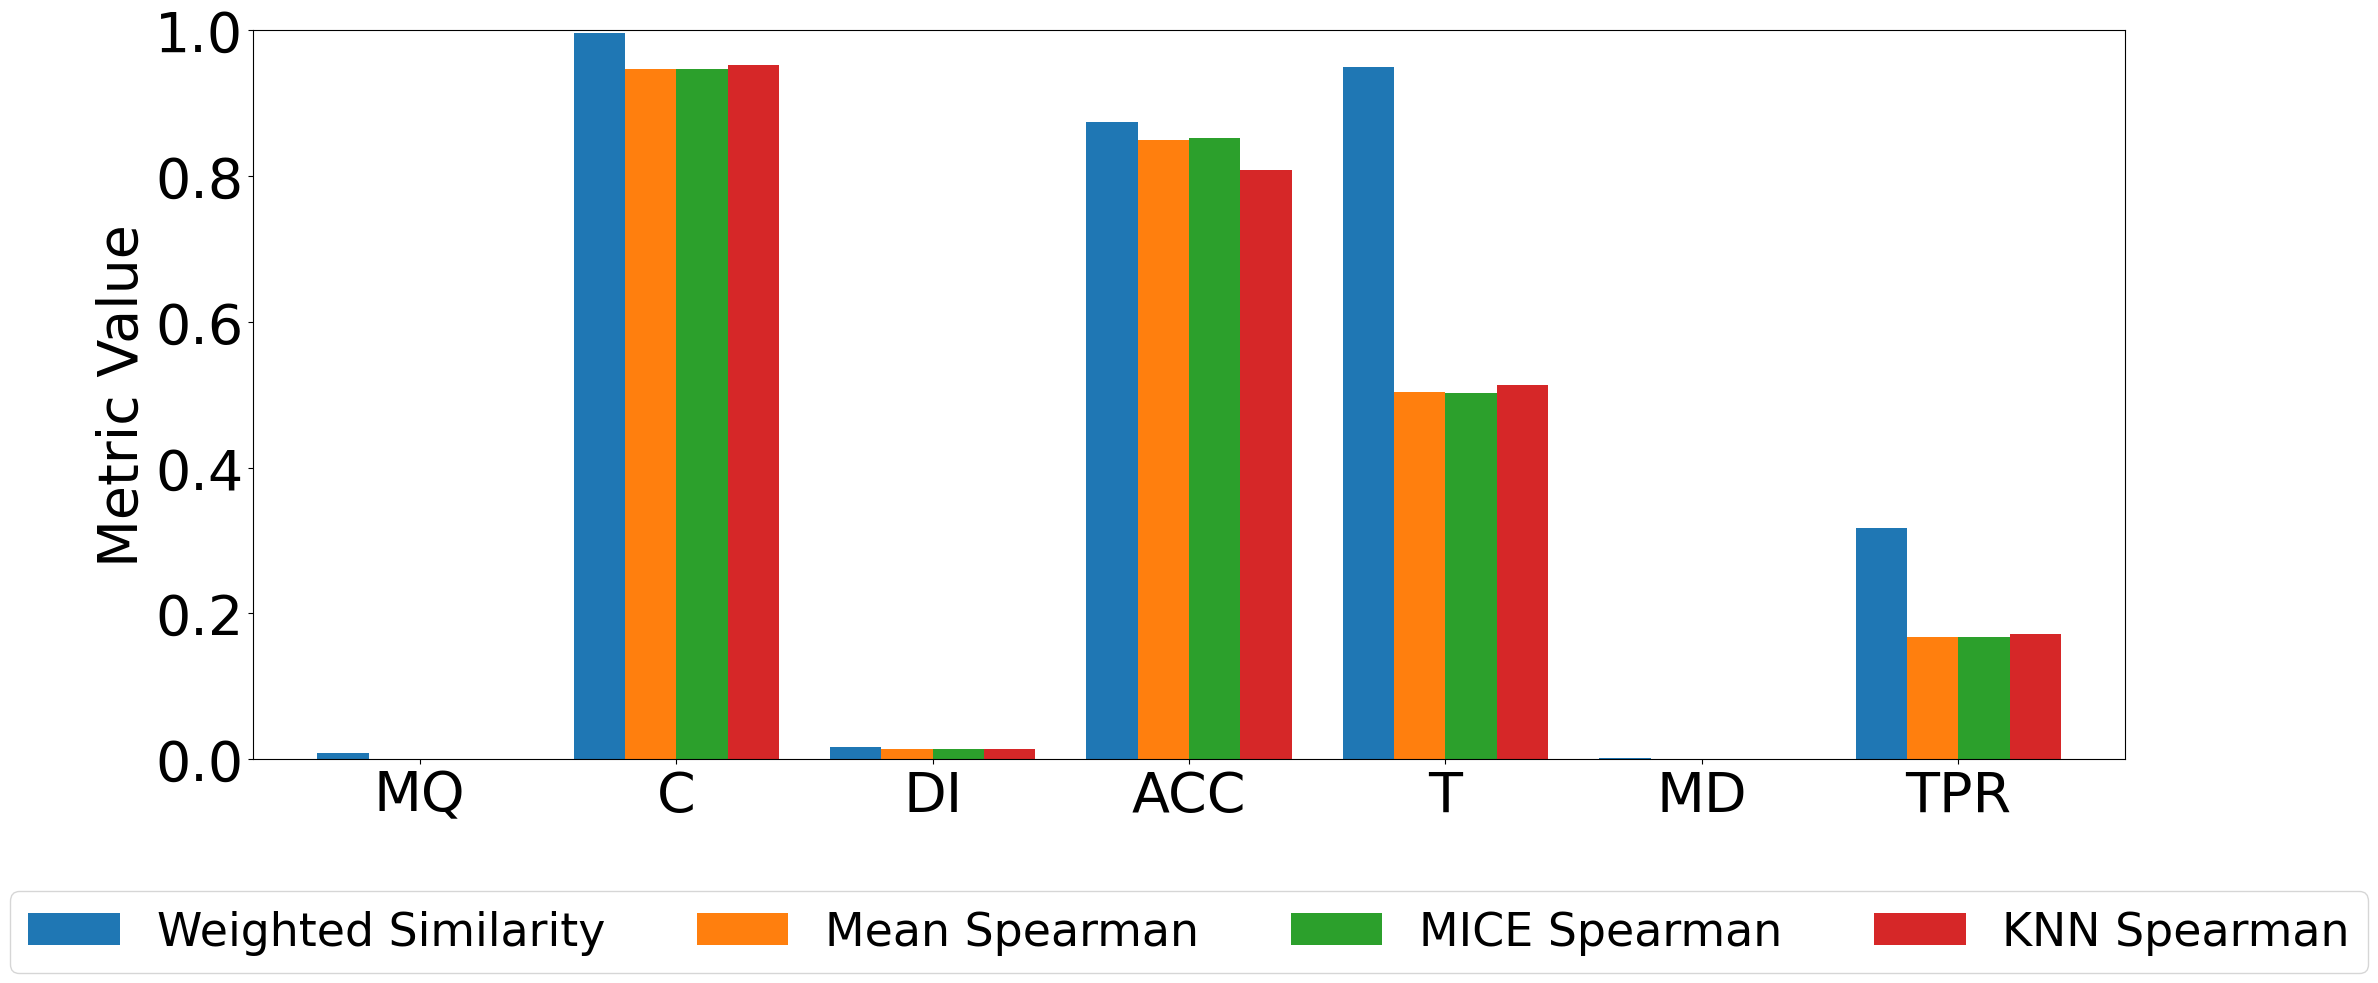

In [598]:
# Example usage:
# Assume comparison_df has already been created and contains the metrics for various methods
# Selected metrics (rows) to plot
selected_metrics = ["Modularity Q", "Coverage", "Dunn Index", 
                    "Average Clustering Coefficient", "Transitivity", "Modularity Density", "Triangle Participation Ratio"]

# Custom row names
custom_row_names = ["MQ", "C", "DI", 
                    "ACC", "T", "MD", "TPR"]

# Selected dataframes (columns) to plot
selected_dataframes = ["DataFrame 1", "DataFrame 11", "DataFrame 12", "DataFrame 13"]  # Replace with actual DataFrame names

# Custom column names
custom_column_names = ["Weighted Similarity", "Mean Spearman", "MICE Spearman", "KNN Spearman"]  # Replace with desired names

# Plot the bar graph with custom column and row names
#plot_selected_comparison_bar_graphs(comparison_df, selected_metrics, selected_dataframes, custom_column_names, custom_row_names)
plot_selected_comparison_bar_graphs(comparison_df, selected_metrics, selected_dataframes, custom_column_names, custom_row_names, save_as_pdf=True, pdf_filename='c34_plot.pdf')

#Cosine
#Euclidean
#canberra
#Spearman
#Chebyshev



In [600]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_selected_average_community_metrics(comparison_df, community_ids, selected_dataframes, selected_metrics, custom_column_names=None, custom_community_names=None, custom_metric_names=None, save_as_pdf=False, pdf_filename='average_community_metrics_comparison.pdf'):
    """
    Plots bar graphs comparing the average community metrics in comparison_df for the selected dataframes.

    Parameters:
    - comparison_df: DataFrame containing the comparison metrics.
    - community_ids: List of community IDs (e.g., "Community 1", "Community 2") to calculate averages for.
    - selected_dataframes: List of dataframes (columns) to plot.
    - selected_metrics: List of metrics to include in the plot.
    - custom_column_names: List of custom names for the columns (optional).
    - custom_community_names: List of custom names for the communities (optional).
    - custom_metric_names: Dictionary of custom metric names (optional).
    - save_as_pdf: Boolean flag to save the plot as a PDF file (default: False).
    - pdf_filename: Filename for the saved PDF file (default: 'average_community_metrics_comparison.pdf').
    """
    selected_metric_names = [f"{metric} for {community}" for community in community_ids for metric in selected_metrics]

    # Filter the comparison DataFrame based on selected metrics and dataframes
    filtered_df = comparison_df.loc[selected_metric_names, selected_dataframes].replace("-", np.nan).dropna()

    # Calculate the average value of each metric across all selected communities
    averages_df = filtered_df.groupby(filtered_df.index.str.split(' for ').str[0]).mean()

    # Rename columns if custom_column_names are provided
    if custom_column_names:
        averages_df.columns = custom_column_names

    # Rename metrics for the communities if custom_metric_names are provided
    if custom_metric_names:
        averages_df.rename(index=custom_metric_names, inplace=True)

    # Plot bar graph for the average metrics
    ax = averages_df.plot(kind='bar', figsize=(24, 10), width=0.8)
    ax.set_ylabel('Average Metric Value', fontsize=40)
    #ax.set_title('Average Comparison of Community Metrics', fontsize=18)
    plt.xticks(rotation=360, ha='center', fontsize=40)
    plt.yticks(fontsize=40)
    ax.set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(averages_df.columns), prop={'size': 33})
    plt.tight_layout()

    if save_as_pdf:
        plt.savefig(pdf_filename)

    plt.show()



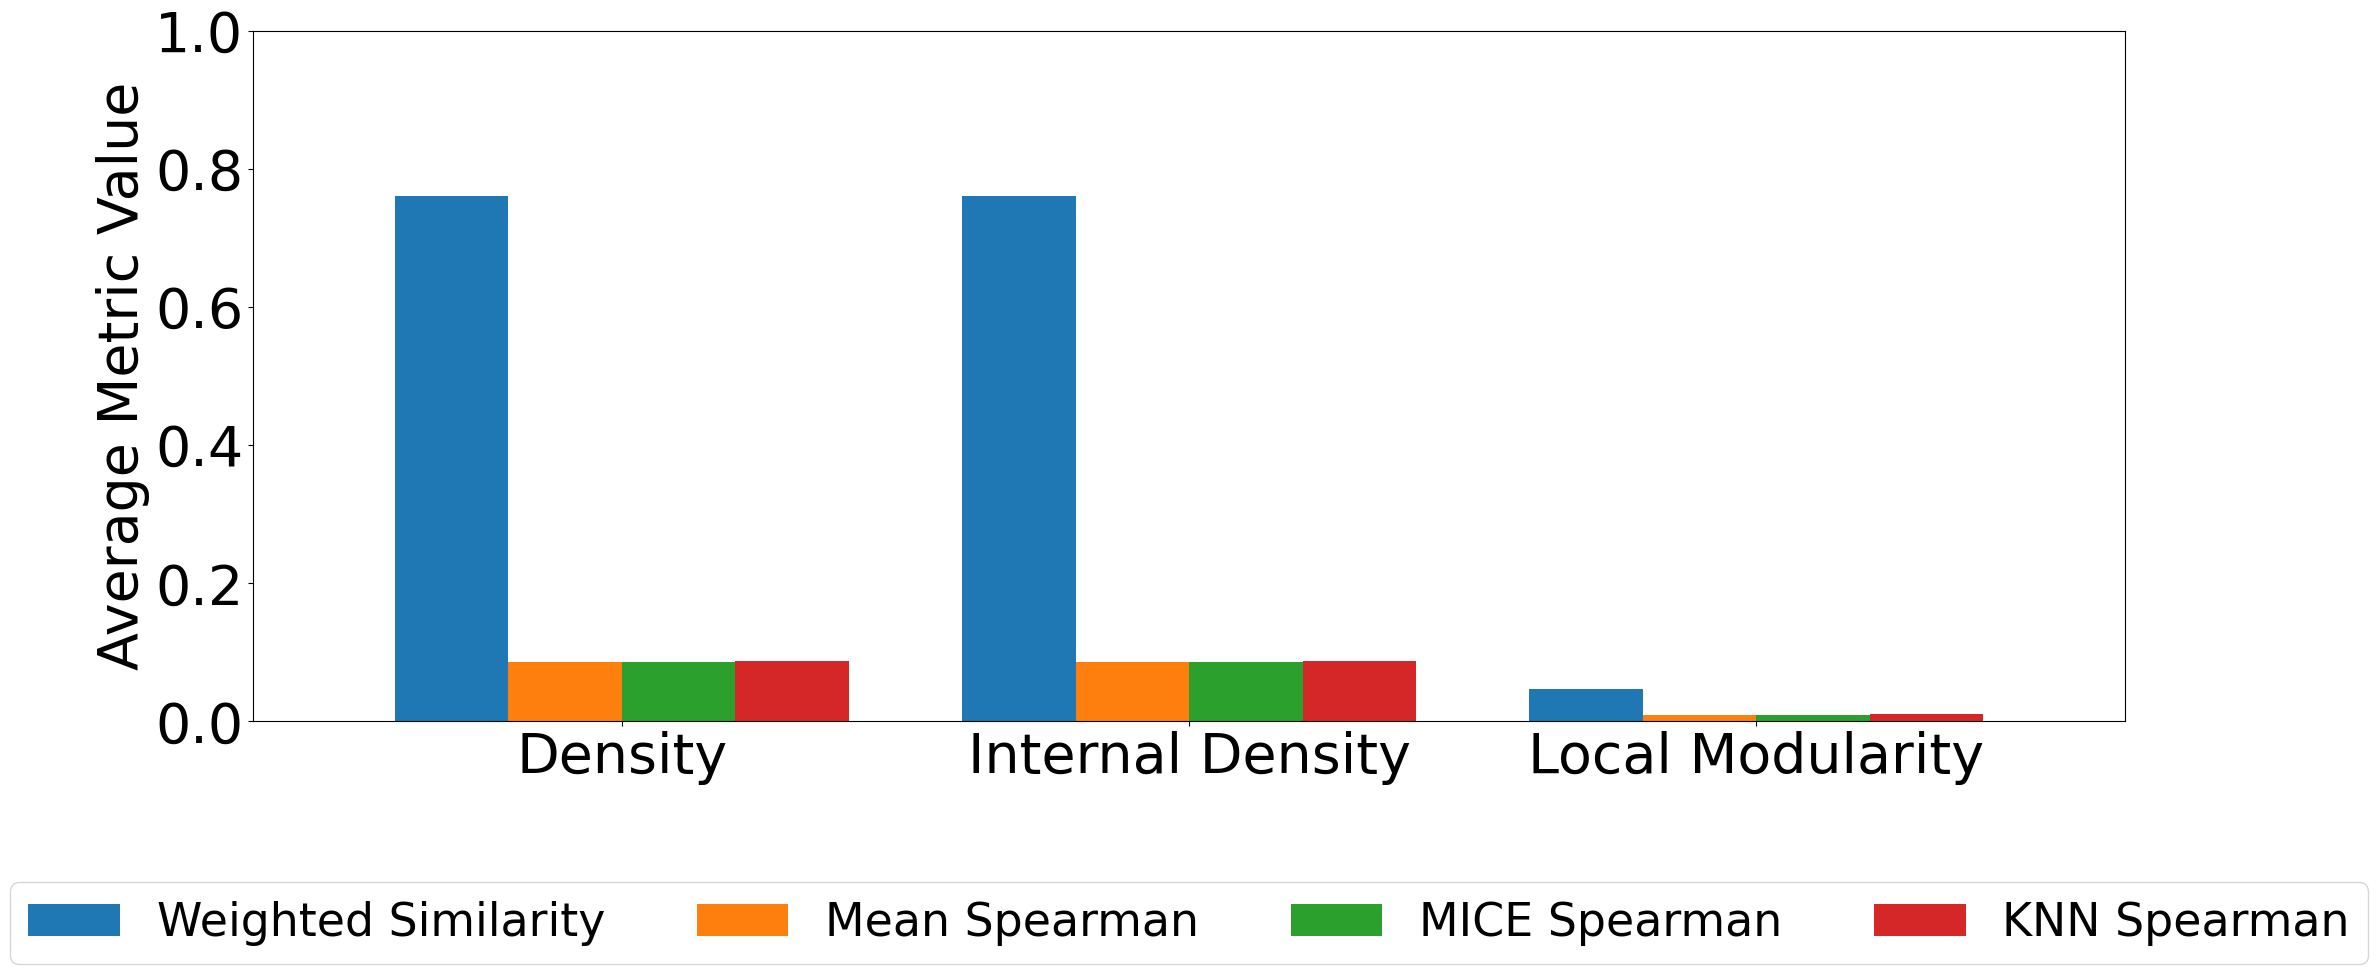

In [604]:
# Example usage:
# Assume comparison_df has already been created and contains the metrics for various methods
# Community IDs to plot
community_ids = [f"Community {i + 1}" for i in range(5)]  # Adjust the range as needed

# Custom metric names
custom_metric_names = {
    "Conductance": "Conduc.",
    "Density": "Density",
    "Local Modularity": "LM",
    "Normalized Cut": "NC",
    "Internal Density": "ID",
    "Expansion": "Expan."
}

# Selected dataframes (columns) to plot
selected_dataframes = ["DataFrame 1", "DataFrame 11", "DataFrame 12", "DataFrame 13"]  # Replace with actual DataFrame names

# Custom column names
custom_column_names = ["Weighted Similarity", "Mean Spearman", "MICE Spearman", "KNN Spearman"]  # Replace with desired names

# Selected metrics to plot
#selected_metrics = ["Conductance", "Expansion", "Normalized Cut"]  # Replace with desired metrics
selected_metrics = ["Density", "Internal Density", "Local Modularity"]  # Replace with desired metrics

# Plot the bar graph for the average metrics with custom column and metric names, and save as PDF
plot_selected_average_community_metrics(comparison_df, community_ids, selected_dataframes, selected_metrics, custom_column_names, custom_metric_names, save_as_pdf=True, pdf_filename='a3H4.pdf')


#Cosine
#Euclidean
#canberra
#Spearman
#Chebyshev


In [605]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_selected_average_community_metrics(comparison_df, community_ids, selected_dataframes, selected_metrics, custom_column_names=None, custom_community_names=None, custom_metric_names=None, colors=None, save_as_pdf=False, pdf_filename='average_community_metrics_comparison.pdf'):
    """
    Plots bar graphs comparing the average community metrics in comparison_df for the selected dataframes.

    Parameters:
    - comparison_df: DataFrame containing the comparison metrics.
    - community_ids: List of community IDs (e.g., "Community 1", "Community 2") to calculate averages for.
    - selected_dataframes: List of dataframes (columns) to plot.
    - selected_metrics: List of metrics to include in the plot.
    - custom_column_names: List of custom names for the columns (optional).
    - custom_community_names: List of custom names for the communities (optional).
    - custom_metric_names: Dictionary of custom metric names (optional).
    - colors: List of colors for the bars (optional).
    - save_as_pdf: Boolean flag to save the plot as a PDF file (default: False).
    - pdf_filename: Filename for the saved PDF file (default: 'average_community_metrics_comparison.pdf').
    """
    selected_metric_names = [f"{metric} for {community}" for community in community_ids for metric in selected_metrics]

    # Filter the comparison DataFrame based on selected metrics and dataframes
    filtered_df = comparison_df.loc[selected_metric_names, selected_dataframes].replace("-", np.nan).dropna()

    # Calculate the average value of each metric across all selected communities
    averages_df = filtered_df.groupby(filtered_df.index.str.split(' for ').str[0]).mean()

    # Rename columns if custom_column_names are provided
    if custom_column_names:
        averages_df.columns = custom_column_names

    # Rename metrics for the communities if custom_metric_names are provided
    if custom_metric_names:
        averages_df.rename(index=custom_metric_names, inplace=True)

    # Plot bar graph for the average metrics
    ax = averages_df.plot(kind='bar', figsize=(24, 10), width=0.8, color=colors)
    ax.set_ylabel('Average Metric Value', fontsize=40)
    plt.xticks(rotation=360, ha='center', fontsize=40)
    plt.yticks(fontsize=40)
    ax.set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(averages_df.columns), prop={'size': 33})
    plt.tight_layout()

    if save_as_pdf:
        plt.savefig(pdf_filename)

    plt.show()



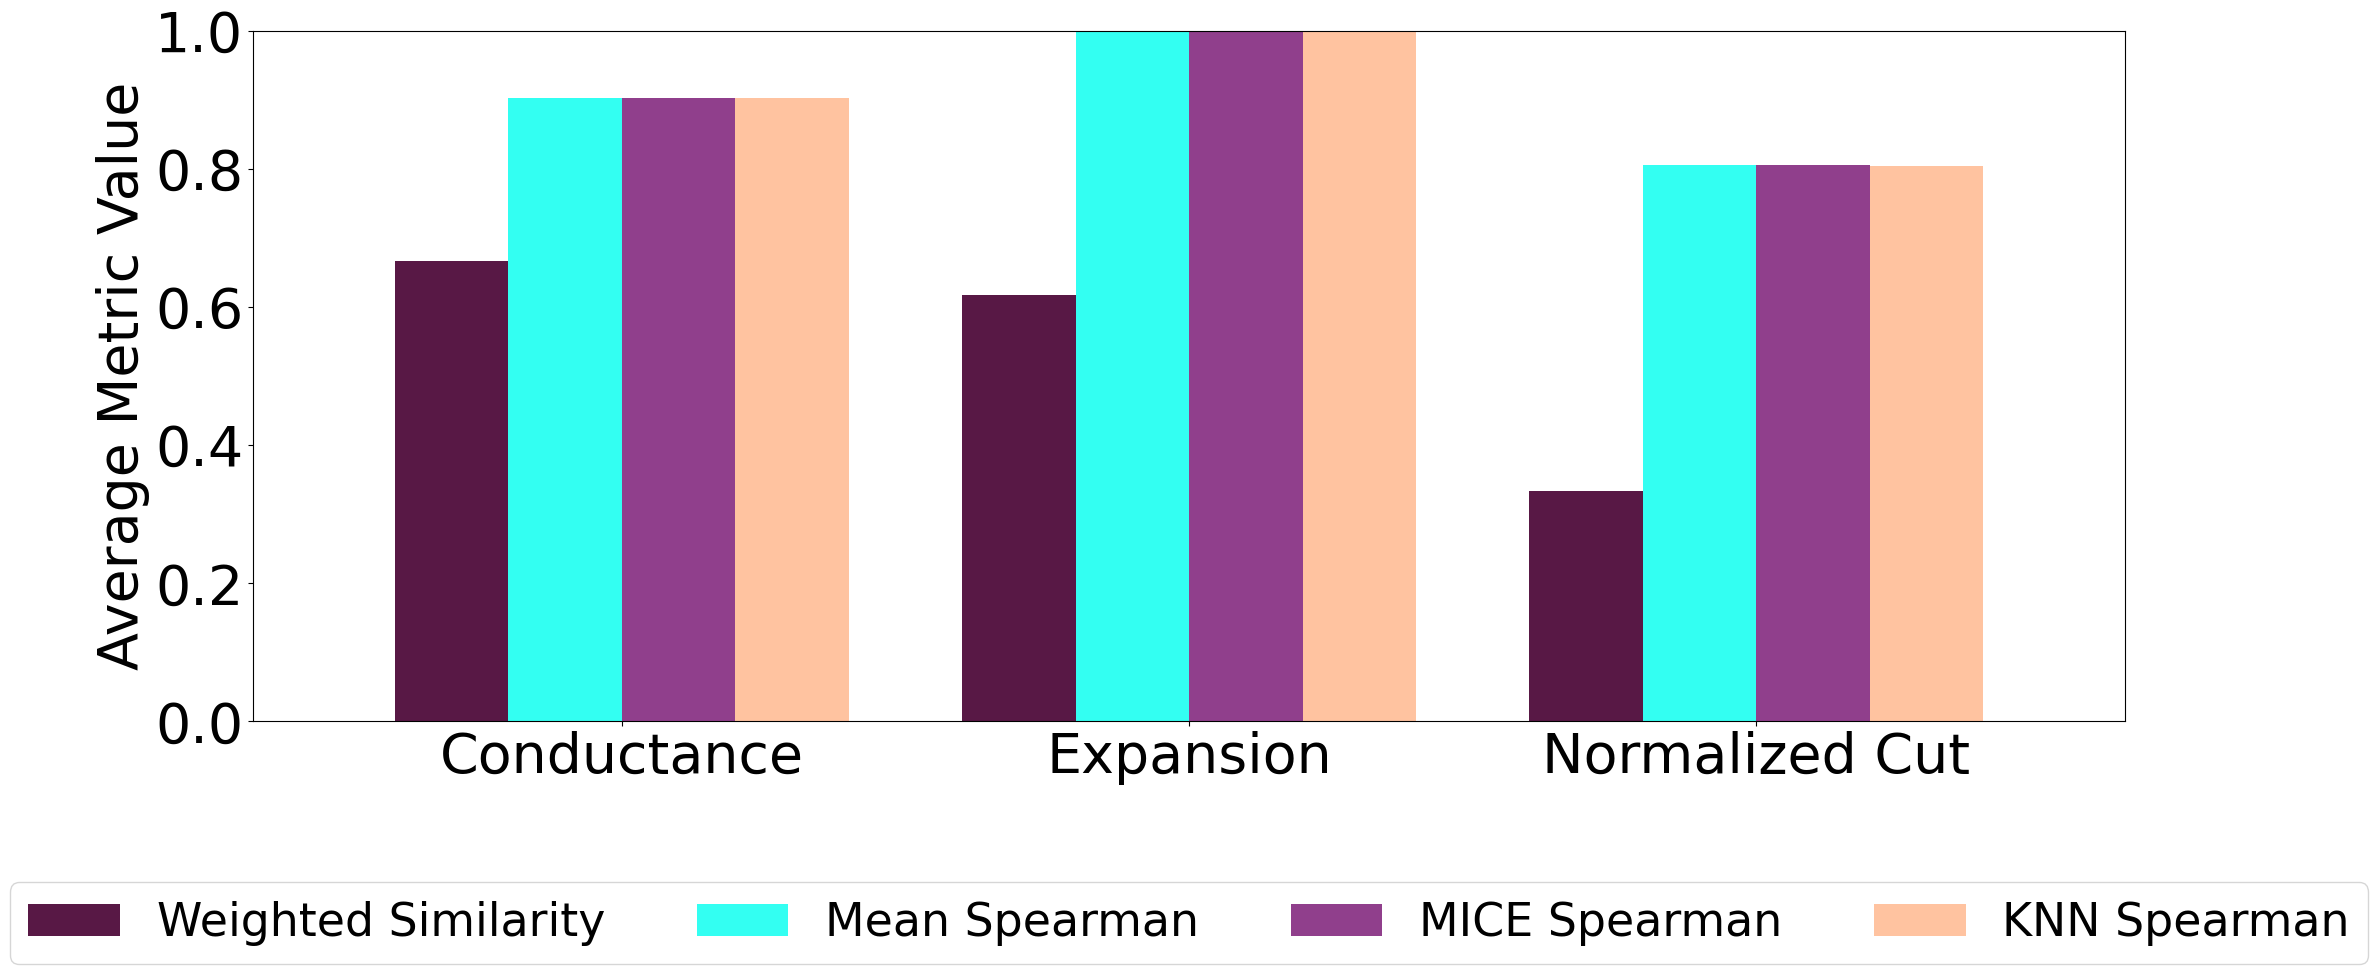

In [609]:
# Example usage:
# Assume comparison_df has already been created and contains the metrics for various methods
# Community IDs to plot
community_ids = [f"Community {i + 1}" for i in range(5)]  # Adjust the range as needed

# Custom metric names
custom_metric_names = {
    "Conductance": "Conduc.",
    "Density": "Density",
    "Local Modularity": "LM",
    "Normalized Cut": "NC",
    "Internal Density": "ID",
    "Expansion": "Expan."
}

# Selected dataframes (columns) to plot
selected_dataframes = ["DataFrame 1", "DataFrame 11", "DataFrame 12", "DataFrame 13"]  # Replace with actual DataFrame names

# Custom column names
custom_column_names = ["Weighted Similarity", "Mean Spearman", "MICE Spearman", "KNN Spearman"]  # Replace with desired names

# Selected metrics to plot
selected_metrics = ["Conductance", "Expansion", "Normalized Cut"]  # Replace with desired metrics
#selected_metrics = ["Density", "Internal Density", "Local Modularity"]  # Replace with desired metrics

colors = [
    '#581845', '#33FFF2', '#903F8C', '#FFC3A0'
]

# Plot the bar graph for the average metrics with custom column and metric names, and save as PDF
plot_selected_average_community_metrics(comparison_df, community_ids, selected_dataframes, selected_metrics, custom_column_names, custom_metric_names, colors=colors,  save_as_pdf=True, pdf_filename='a3L4.pdf')


#Cosine
#Euclidean
#canberra
#Spearman
#Chebyshev
